In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)

from plot_offline import *
fig_dir = '../figs'

In [3]:
#Python-related imports
import math
from datetime import datetime
import os.path

In [4]:
#Module module imports
from SBM_SDE_classes import *

## Testing CO2 inference

In [5]:
#PyTorch settings
torch.manual_seed(0)
active_device = torch.device('cpu')
active_device

device(type='cpu')

In [43]:
#Neural SDE parameters
dt_flow = 1.0 #Increased from 0.1 to reduce memory.
t = 1000 #In hours.
n = int(t / dt_flow) + 1
t_span = np.linspace(0, t, n)
t_span_tensor = torch.reshape(torch.Tensor(t_span), [1, n, 1]).to(active_device) #T_span needs to be converted to tensor object. Additionally, facilitates conversion of I_S and I_D to tensor objects.

#SBM temperature forcing parameters
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

#Training parameters
niter = 300000
train_lr = 2e-5 #ELBO learning rate
batch_size = 30 #3 - number needed to fit UCI HPC3 RAM requirements with 16 GB RAM at t = 5000.
eval_batch_size = 30
obs_error_scale = 0.1 #Observation (y) standard deviation.
prior_scale_factor = 0.333 #Proportion of prior standard deviation to prior means.
num_layers = 5 #5 - number needed to fit UCI HPC3 RAM requirements with 16 GB RAM at t = 5000.

#Specify desired SBM SDE model type and details.
state_dim_SCON = 3
sbm_sde_class = 'SCON'
diffusion_type = 'C'
learn_CO2 = True
theta_dist = 'TruncatedNormal' #String needs to be exact name of the distribution class. Other option is 'RescaledLogitNormal

#Generate exogenous input vectors.
#Obtain temperature forcing function.
temp_tensor = temp_gen(t_span_tensor, temp_ref, temp_rise).to(active_device)

#Obtain SOC and DOC pool litter input vectors for use in flow SDE functions.
i_s_tensor = i_s(t_span_tensor).to(active_device) #Exogenous SOC input function
i_d_tensor = i_d(t_span_tensor).to(active_device) #Exogenous DOC input function

In [44]:
now = datetime.now()
now_string = 'SCON-C_CO2_trunc_' + now.strftime('%Y_%m_%d_%H_%M_%S')
save_string = f'_iter_{niter}_t_{t}_dt_{dt_flow}_batch_{batch_size}_layers_{num_layers}_lr_{train_lr}_sd_scale_{prior_scale_factor}_{now_string}.pt'
outputs_folder = '../training_pt_outputs/'
plots_folder = '../training_plots/'

In [45]:
theta_file_CO2 = torch.load('../generated_data/SCON-C_CO2_trunc_sample_y_t_1000_dt_0-01_sd_scale_0-333_rsample.pt', map_location = active_device)
obs_model_file_CO2 = torch.load('../training_pt_outputs/obs_model_iter_300000_t_1000_dt_1.0_batch_30_layers_5_lr_2e-05_sd_scale_0.333_SCON-C_CO2_trunc_2021_09_07_12_26_21.pt', map_location = active_device)
net_file_CO2 = torch.load('../training_pt_outputs/net_iter_300000_t_1000_dt_1.0_batch_30_layers_5_lr_2e-05_sd_scale_0.333_SCON-C_CO2_trunc_2021_09_07_12_26_21.pt', map_location = active_device)
q_theta_file_CO2 = torch.load('../training_pt_outputs/q_theta_iter_300000_t_1000_dt_1.0_batch_30_layers_5_lr_2e-05_sd_scale_0.333_SCON-C_CO2_trunc_2021_09_07_12_26_21.pt', map_location = active_device)

/usr/local/lib/python3.9/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.9/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.9/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

In [46]:
net_file_CO2.device = active_device
net_file_CO2.eval()

SDEFlow(
  (obs_model): ObsModel()
  (affine): ModuleList(
    (0): AffineLayer(
      (feature_net): Sequential(
        (0): ResNetBlockUnMasked(
          (conv1): Conv1d(5, 96, kernel_size=(3,), stride=(1,), padding=(1,))
          (conv2): Conv1d(96, 96, kernel_size=(3,), stride=(1,), padding=(1,))
          (act1): PReLU(num_parameters=96)
          (act2): PReLU(num_parameters=96)
          (bn1): Identity()
          (bn2): Identity()
          (conv_skip): Conv1d(5, 96, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        )
        (1): ResNetBlockUnMasked(
          (conv1): Conv1d(96, 5, kernel_size=(3,), stride=(1,), padding=(1,))
          (conv2): Conv1d(5, 5, kernel_size=(3,), stride=(1,), padding=(1,))
          (act1): PReLU(num_parameters=5)
          (act2): PReLU(num_parameters=5)
          (bn1): Identity()
          (bn2): Identity()
          (conv_skip): Conv1d(96, 5, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        )
      )
      (f

In [47]:
x, _ = net_file_CO2(eval_batch_size)

In [48]:
x.size()

torch.Size([30, 1001, 3])

In [49]:
def plot_states_post(x, q_theta, SBM_SDE_CLASS, DIFFUSION_TYPE, TEMP_TENSOR, TEMP_REF, obs_model, niter, t, dt, batch_size, eval_batch_size, num_layers, train_lr, sd_scale, plots_folder, now_string, LEARN_CO2 = False, ymin_list = None, ymax_list = None):

    state_list = []

    if x.size(-1) == 3 and not LEARN_CO2:
        state_list = ['SOC', 'DOC', 'MBC']
    elif x.size(-1) == 3 and LEARN_CO2:
        state_list = ['SOC', 'DOC', 'MBC', 'CO2']
    elif x.size(-1) == 4 and not LEARN_CO2:
        state_list = ['SOC', 'DOC', 'MBC', 'EEC']
    elif x.size(-1) == 4 and LEARN_CO2:
        state_list = ['SOC', 'DOC', 'MBC', 'EEC', 'CO2']
    else:
        raise Exception('Matching condition does not exist with x.size() and LEARN_CO2 status.')

    #Instantiate SBM_SDE object based on specified model and diffusion type.
    SBM_SDE_class_dict = {
            'SCON': SCON,
            'SAWB': SAWB,
            'SAWB-ECA': SAWB_ECA
            }
    if SBM_SDE_CLASS not in SBM_SDE_class_dict:
        raise NotImplementedError('Other SBM SDEs aside from SCON, SAWB, and SAWB-ECA have not been implemented yet.')
    SBM_SDE_class = SBM_SDE_class_dict[SBM_SDE_CLASS]
    SBM_SDE = SBM_SDE_class(DIFFUSION_TYPE)

    if LEARN_CO2:
        q_theta_sample_dict, _, _, _ = q_theta(x.size(0))
        x = SBM_SDE.add_CO2(x, q_theta_sample_dict, TEMP_TENSOR, TEMP_REF) #Add CO2 to x tensor if CO2 is being fit.

    fig, axs = plt.subplots(x.size(-1))

    obs_model.mu = obs_model.mu.detach().cpu().numpy()
    obs_model.scale = obs_model.scale.detach().cpu().numpy()

    for i in range(x.size(-1)):
        q_mean, q_std = x[:, :, i].mean(0).detach().cpu().numpy(), x[:, :, i].std(0).detach().cpu().numpy()
        hours = torch.arange(0, t + dt, dt).detach().cpu().numpy()
        axs[i].plot(obs_model.times, obs_model.mu[i, :], linestyle = 'None', marker = '.', label = 'Observed')
        axs[i].fill_between(obs_model.times, obs_model.mu[i, :] - 2 * obs_model.scale[:, i], obs_model.mu[i, :] + 2 * obs_model.scale[:, i], alpha = 0.4, label = 'Observation $\\mu \pm 2\sigma_y$')
        axs[i].plot(hours, q_mean, label = 'Posterior mean')
        axs[i].fill_between(hours, q_mean - 2 * q_std, q_mean + 2 * q_std, alpha = 0.4, label = 'Posterior $\\mu \pm 2\sigma_x$')
        state = state_list[i]
        #axs[i].legend()
        plt.setp(axs[i], ylabel = state)
        ymin = ymin_list[i]
        ymax = ymax_list[i]
        axs[i].set_ylim([ymin, ymax])
        #plt.title(f'Approximate posterior $q(x|\\theta, y)$\nNumber of samples = {eval_batch_size}\nTimestep = {dt}\nIterations = {niter}')
    plt.xlabel('Hour')
    plt.tight_layout()
    fig.set_size_inches(15, 15)
    fig.savefig(os.path.join(plots_folder, f'net_iter_{niter}_t_{t}_dt_{dt}_batch_{batch_size}_samples_{eval_batch_size}_layers_{num_layers}_lr_{train_lr}_sd_scale_{sd_scale}_{now_string}.png'), dpi = 300)

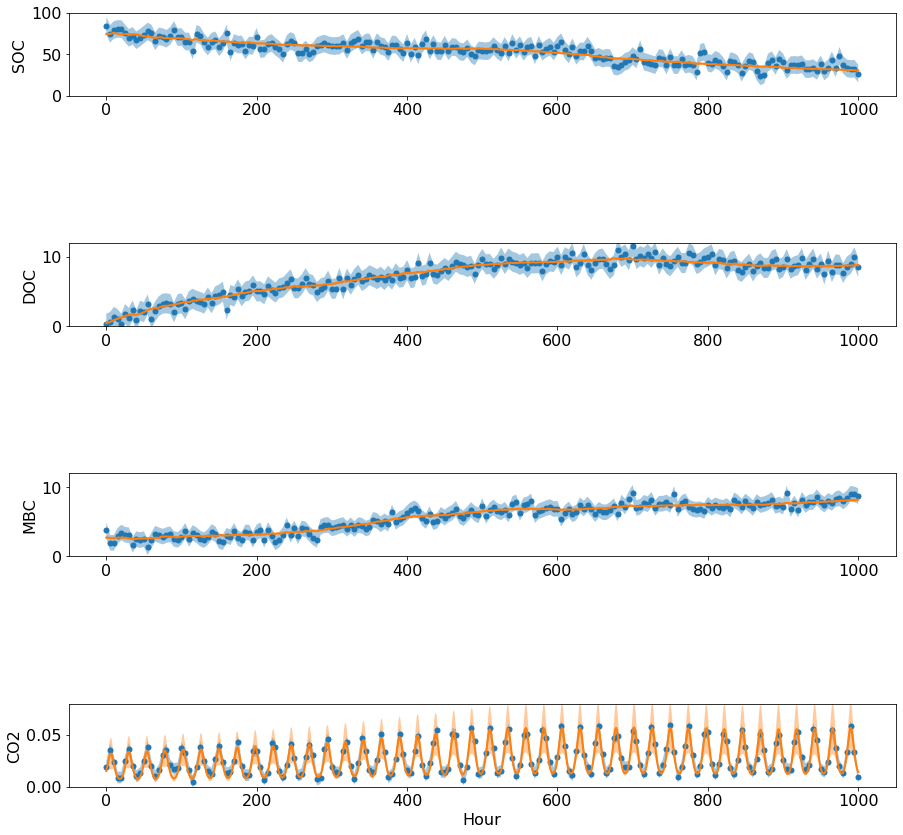

In [50]:
plot_states_post(x, q_theta_file_CO2, 'SCON', 'C', temp_tensor, temp_ref, obs_model_file_CO2, niter, t, dt_flow, batch_size, eval_batch_size, num_layers, train_lr, prior_scale_factor, plots_folder, now_string, learn_CO2, ymin_list = [0, 0, 0, 0], ymax_list = [100., 12., 12., 0.08])

## Truncated-normal theta distribution

In [ ]:
#net_file = '../training_pt_outputs/net_iter_390000_t_1000_dt_1.0_batch_35_layers_5_lr_0.0005_sd_scale_0.333_SCONR_C_fix_a_Ea_trunc_2021_08_09_05_54_02.pt'
#kf_file = '../training_pt_outputs/kf_fix_a_Ea_trunc.pt'
p_file = '../training_pt_outputs/p_theta_iter_440000_t_1000_dt_1.0_batch_32_layers_5_lr_0.0001_sd_scale_0.333_SCONR_C_fix_u_M_a_Ea_c_trunc_2021_08_20_12_26_52.pt'
q_file = '../training_pt_outputs/q_theta_iter_440000_t_1000_dt_1.0_batch_32_layers_5_lr_0.0001_sd_scale_0.333_SCONR_C_fix_u_M_a_Ea_c_trunc_2021_08_20_12_26_52.pt'
theta_file = '../generated_data/SCONR_C_fix_u_M_a_Ea_c_trunc_sample_y_t_1000_dt_0-01_sd_scale_0-333_rsample.pt'

In [ ]:
plot_states(net_file, kf_file, 'states_fix_a_Ea_trunc_each.png', fig_dir=fig_dir, summarize_net=False,
            ymin_list = [0, 0, 0], ymax_list = [100., 12., 13.], num_samples=50)

In [ ]:
plot_states(net_file, kf_file, 'states_fix_a_Ea_trunc.png', fig_dir=fig_dir,
            ymin_list = [0, 0, 0], ymax_list = [100., 12., 13.], num_samples=50)

In [ ]:
plot_theta(p_file, q_file, theta_file, 'theta_fix_u_M_a_Ea_c_trunc.png', fig_dir=fig_dir)

## Logit-normal theta distribution

In [ ]:
#net_file = '../training_pt_outputs/net_iter_390000_t_1000_dt_1.0_batch_35_layers_5_lr_0.0005_sd_scale_0.333_SCONR_C_fix_a_Ea_logit_alt_2021_08_09_05_58_42.pt'
#kf_file = '../training_pt_outputs/kf_fix_a_Ea_logit_alt.pt'
p_file = '../training_pt_outputs/p_theta_iter_390000_t_1000_dt_1.0_batch_30_layers_5_lr_0.0001_sd_scale_0.333_SCONR_C_fix_u_M_a_Ea_c_logit_alt_2021_08_24_11_37_13.pt'
q_file = '../training_pt_outputs/q_theta_iter_390000_t_1000_dt_1.0_batch_30_layers_5_lr_0.0001_sd_scale_0.333_SCONR_C_fix_u_M_a_Ea_c_logit_alt_2021_08_24_11_37_13.pt'
theta_file = '../generated_data/SCONR_C_fix_u_M_a_Ea_c_logit_alt_sample_y_t_1000_dt_0-01_sd_scale_0-333_rsample.pt'


In [ ]:
plot_states(net_file, kf_file, 'states_fix_a_Ea_logit_each.png', fig_dir=fig_dir, summarize_net=False,
            ymin_list = [0, 0, 0], ymax_list = [100., 12., 10.], num_samples=50)

In [ ]:
plot_states(net_file, kf_file, 'states_fix_a_Ea_logit.png', fig_dir=fig_dir,
            ymin_list = [0, 0, 0], ymax_list = [100., 12., 10.], num_samples=50)

In [ ]:
plot_theta(p_file, q_file, theta_file, 'theta_fix_u_M_a_Ea_c_logit.png', fig_dir=fig_dir)

## Truncated-normal prior, multivariate logit-normal posterior

In [ ]:
kf_file = '../training_pt_outputs/kf_trunc.pt'
theta_file = '../generated_data/SCON_C_trunc_sample_y_t_1000_dt_0-01_sd_scale_0-333_rsample.pt'
net_file = '../training_pt_outputs/net_iter_400000_t_1000_dt_1.0_batch_35_layers_5_lr_0.0005_sd_scale_0.333_SCON_C_trunc_multi_2021_08_10_15_46_21.pt'
p_file = '../training_pt_outputs/p_theta_iter_400000_t_1000_dt_1.0_batch_35_layers_5_lr_0.0005_sd_scale_0.333_SCON_C_trunc_multi_2021_08_10_15_46_21.pt'
q_file = '../training_pt_outputs/q_theta_iter_400000_t_1000_dt_1.0_batch_35_layers_5_lr_0.0005_sd_scale_0.333_SCON_C_trunc_multi_2021_08_10_15_46_21.pt'

In [ ]:
plot_states(net_file, kf_file, 'states_multivar_each.png', fig_dir=fig_dir, summarize_net=False,
            ymin_list = [0, 0, 0], ymax_list = [100., 12., 10.], num_samples=50)

In [ ]:
plot_states(net_file, kf_file, 'states_multivar.png', fig_dir=fig_dir,
            ymin_list = [0, 0, 0], ymax_list = [100., 12., 10.], num_samples=50)

In [ ]:
plot_theta(p_file, q_file, theta_file, 'theta_multivar.png', fig_dir=fig_dir)

## Truncated-normal prior, multivariate logit-normal posterior, empirical plots

- Empirical, posterior marginal theta plots
- Empirical correlation plots

In [ ]:
q_file = '../training_pt_outputs/q_theta_iter_400000_t_1000_dt_1.0_batch_35_layers_5_lr_0.0005_sd_scale_0.333_SCON_C_trunc_multi_2021_08_10_15_46_21.pt'
q_theta = torch.load(q_file, map_location=torch.device('cpu'))


In [ ]:
parent_loc = q_theta.means
parent_scale_tril = D.transform_to(q_theta.dist.arg_constraints['scale_tril'])(q_theta.sds)

In [ ]:
q_theta.dist

In [ ]:
q_dist = q_theta.dist(parent_loc, scale_tril=parent_scale_tril, a = q_theta.lowers, b = q_theta.uppers)

In [ ]:
samples = q_dist.rsample([10])
q_dist.log_prob(samples)

In [ ]:
torch.sum(q_dist.log_prob(samples), -1)

In [ ]:
q_file_univar = '../training_pt_outputs/q_theta_iter_390000_t_1000_dt_1.0_batch_30_layers_5_lr_0.0001_sd_scale_0.333_SCONR_C_fix_u_M_a_Ea_c_logit_alt_2021_08_24_11_37_13.pt'
q_theta_univar = torch.load(q_file_univar, map_location=torch.device('cpu'))
parent_loc_uni = q_theta_univar.means
parent_scale_uni = torch.max(q_theta_univar.sds, torch.tensor(1e-6))
q_dist_uni = q_theta_univar.dist(parent_loc_uni, parent_scale_uni, a = q_theta_univar.lowers, b = q_theta_univar.uppers)

In [ ]:
samples_uni = q_dist_uni.sample((10, ))
q_dist_uni.log_prob(samples_uni)

In [ ]:
torch.sum(q_dist_uni.log_prob(samples_uni), -1)

## ELBO

In [ ]:
device=torch.device('cpu')
p_dist = torch.load(p_file, map_location=device)
q_theta = torch.load(q_file, map_location=device)

In [ ]:
q_theta.learn_cov

In [ ]:
loc = q_theta.means
scale_tril = D.transform_to(q_theta.dist.arg_constraints['scale_tril'])(q_theta.sds)
scale = torch.diag(scale_tril)
lower = q_theta.lowers
upper = q_theta.uppers

In [ ]:
q_marg = RescaledLogitNormal(loc, scale, a = lower, b = upper)

In [ ]:
cov_mat = scale_tril @ scale_tril.T
plt.imshow(cov_mat.detach())
plt.colorbar()

In [ ]:
cov_mat = scale_tril @ scale_tril.T
plt.imshow(cov_mat.detach(), cmap='coolwarm', vmin=-0.1, vmax=0.1)
plt.colorbar()

In [ ]:
scale = torch.diag(cov_mat).sqrt()
scale_prod = torch.outer(scale, scale)

In [ ]:
cov_mat

In [ ]:
scale_prod

In [ ]:
corr = cov_mat / scale_prod
corr

In [ ]:
num_params = len(loc)
plt.figure(figsize = (8, 8))
plt.imshow(corr.detach(), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(num_params), labels=q_theta.keys, rotation='vertical')
plt.yticks(range(num_params), labels=q_theta.keys)
plt.title('Correlation between parameters');

In [ ]:
elbo_file = '../training_pt_outputs/ELBO_iter_450000_t_1000_dt_1.0_batch_15_layers_5_lr_0.0005_sd_scale_0.333_trunc_2021_07_18_10_20_15.pt'

In [ ]:
elbo_hist = torch.load(elbo_file, map_location=torch.device('cpu'))

In [ ]:
plt.plot(elbo_hist[200000:], linewidth=1)

In [ ]:
q_theta = torch.load('../this_week/q_theta_trunc.pt', map_location=torch.device('cpu'))
p_theta = torch.load('../this_week/p_theta_trunc.pt', map_location=torch.device('cpu'))
theta = torch.load('../this_week/theta_trunc.pt')

In [ ]:
i = q_theta.keys.index('c_SOC')
theta['c_SOC']

In [ ]:
p_theta.loc[i], p_theta.scale[i]

In [ ]:
lower = q_theta.lowers
upper = q_theta.uppers
p_theta.loc[i], p_theta.scale[i], lower[i], upper[i]

In [ ]:
from TruncatedNormal import *
x = torch.from_numpy(np.linspace(0, 0.2, 10000))
pdf = TruncatedNormal(p_theta.loc[i], p_theta.scale[i], lower[i], upper[i]).log_prob(x)

In [ ]:
x

In [ ]:
x.shape

In [ ]:
plt.plot(x[:, i], pdf[:, i])

In [ ]:
p_theta.mean

In [ ]:
p_theta.stddev

# Archive

In [ ]:
import torch.distributions as D


In [ ]:
from LogitNormal import *
from TruncatedNormal import *

In [ ]:
x = RescaledLogitNormal()

In [ ]:
x.mean

In [ ]:
x.variance

In [ ]:
x.stddev

### Visualizing $\theta$

TODO:
- Add true theta value
- (Maybe) zoom in

In [ ]:
def plot_theta(p_theta_file, q_theta_file, true_theta_file, nrows=4, ncols=4, device=torch.device('cpu')):
    # Load prior distribution
    p_dist = torch.load(p_theta_file, map_location=device)
    
    # Load posterior distribution
    q_theta = torch.load(q_theta_file, map_location=device)
    loc = q_theta.means
    scale = torch.maximum(q_theta.sds, torch.tensor(1e-6))
    lower = q_theta.lowers
    upper = q_theta.uppers
    q_dist = q_theta.dist(loc, scale, a = lower, b = upper)
    
    # Load true theta
    true_theta = torch.load(true_theta_file, map_location=device)
    
    # Compute prior and posterior densities at points x
    num_pts = 1000
    x = torch.from_numpy(np.linspace(lower, upper, num_pts))
    pdf_prior = torch.exp(q_dist.log_prob(x)).detach()
    pdf_post = torch.exp(p_dist.log_prob(x)).detach()
    
    # Plot
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
    k = 0
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            if k < 14:
                key = q_theta.keys[k]
                ax.plot(x[:, k], pdf_prior[:, k], label='Prior $p(\\theta)$')
                ax.plot(x[:, k], pdf_post[:, k], label='Approximate posterior $q(\\theta)$')
                ax.axvline(true_theta[key], color='gray', label='True $\\theta$')
                ax.set_xlabel(key)
                ax.set_ylabel('density')
            elif k == 14:
                handles, labels = axes[0, 0].get_legend_handles_labels()
                ax.legend(handles, labels, loc='center')
                ax.axis('off')
            else:
                fig.delaxes(axes[i, j])
            k += 1
            
    plt.tight_layout()
    plt.show()

In [ ]:
p_file = '../results/p_theta_logit.pt'
q_file = '../results/q_theta_logit.pt'
true_theta_file = '../results/true_theta_logit.pt'
plot_theta(p_file, q_file, true_theta_file)

In [ ]:
'/'.join(['dir', 'file.png'])

In [ ]:
p_file = '../results/p_theta_trunc.pt'
q_file = '../results/q_theta_trunc.pt'
plot_theta(p_file, q_file)

In [ ]:
loc = q_theta.means
scale = torch.maximum(q_theta.sds, torch.tensor(1e-6))
lower = q_theta.lowers
upper = q_theta.uppers
q_dist = q_theta.dist(loc, scale, a = lower, b = upper)

In [ ]:
num_pts = 1000
x = torch.from_numpy(np.linspace(lower, upper, num_pts)) # (num_pts, event_shape)

In [ ]:
pdf = torch.exp(q_dist.log_prob(x)) # (num_pts, event_shape)

In [ ]:
x.shape, pdf.shape

In [ ]:
plt.plot(x[:, 0], pdf.detach()[:, 0])

In [ ]:
plt.plot(x[:, 0], pdf.detach()[:, 0])

In [ ]:
q_theta.keys

In [ ]:
q_theta.dist

In [ ]:
p_dist = torch.load('../results/p_theta_logit.pt')

In [ ]:
torch.load('../results/p_theta_trunc.pt')

In [ ]:
torch.load('../results/p_theta_logit.pt')

In [ ]:
p_dist.sigmoid

In [ ]:
fig, axes = plt.subplots(2, 2)

In [ ]:
theta_trunc = torch.load('SCON_C_trunc_sample_y_t_1000_dt_0-01_sd_scale_0-333_rsample.pt')

In [ ]:
theta_trunc

### Visualizing `net`

TODO:
- Add Kalman smoother results
- Remove obs stddev

In [ ]:
def plot_net(net_file, kf_file, num_samples=10, ymin_list=None, ymax_list=None, device=torch.device('cpu')):
    # Load net object
    net = torch.load(net_file, map_location=device)
    obs_model, state_dim, t, dt = net.obs_model, net.state_dim, net.t, net.dt
    
    # Load KalmanFilter object
    kf = torch.load(kf_file, map_location=device)
    
    # Draw samples of x
    net.device = device
    net.eval()
    x, _ = net(num_samples)
    
    # Define figure and axes objects
    state_list = ['SOC', 'DOC', 'MBC', 'EEC']
    fig, axs = plt.subplots(state_dim, figsize=(15, 15))
    if ymin_list is None:
        ymin_list = [None] * state_dim
    if ymax_list is None:
        ymax_list = [None] * state_dim
    
    for i in range(state_dim):
        net_mean, net_sd = x[:, :, i].mean(0).detach(), x[:, :, i].std(0).detach()
        kf_mean, kf_sd = kf.mu_smooth[:, i], kf.sigma_smooth[:, i, i].sqrt()
        hours = torch.arange(0, t + dt, dt)
        
        # Plot net posterior
        axs[i].plot(hours, net_mean, label = 'SDE flow mean')
        axs[i].fill_between(hours, net_mean - 2 * net_sd, net_mean + 2 * net_sd,
                            alpha = 0.4, label = 'SDE flow $\\mu \pm 2\sigma_x$')
        
        # Plot kf posterior
        axs[i].plot(hours, kf_mean, label = 'Kalman smoother mean')
        axs[i].fill_between(hours, kf_mean - 2 * kf_sd, kf_mean + 2 * kf_sd,
                            alpha = 0.4, label = 'Kalman smoother $\\mu \pm 2\sigma_x$')
        
        # Plot observations
        axs[i].plot(obs_model.times, obs_model.mu[i, :], linestyle = 'None', marker = '.', label = 'Observed')
        #axs[i].fill_between(obs_model.times, obs_model.mu[i, :] - 2 * obs_model.scale[:, i], obs_model.mu[i, :] + 2 * obs_model.scale[:, i], alpha = 0.4, label = 'Observation $\\mu \pm 2\sigma_y$')
        
        state = state_list[i]
        axs[i].set_ylabel(state) #plt.setp(axs[i], ylabel = state)
        ymin = ymin_list[i]
        ymax = ymax_list[i]
        axs[i].set_ylim([ymin, ymax])
        #plt.title(f'Approximate posterior $q(x|\\theta, y)$\nNumber of samples = {eval_batch_size}\nTimestep = {dt}\nIterations = {niter}')
    
    axs[i].legend()
    plt.xlabel('Hour')

In [ ]:
net_file = '../results/net_trunc.pt'
kf_file = '../results/kf_trunc.pt'
plot_net(net_file, kf_file)

In [ ]:
torch.load('../results/kf_trunc.pt')

In [ ]:
troch

In [ ]:
def plot_post(data, state_idx, plot_sd=False, show_legend=True, labels=['SOC', 'DOC', 'MBC']):
    #plt.figure(figsize=(7, 6))
    obs = data[:, state_idx]
    mean_filter = kf.mu_filter[:, state_idx]
    mean_smooth = kf.mu_smooth[:, state_idx]
    
    if plot_sd:
        sd_filter = kf.sigma_filter[:, state_idx, state_idx].sqrt()
        #rv_filter = dist.normal.Normal(mean_filter, sd_filter)
        #plt.fill_between(T_span, rv_filter.icdf(torch.tensor(0.05)), rv_filter.icdf(torch.tensor(0.95)),
        #                 alpha=0.5, linewidth=0,
        #                 label='Filtered 5-95th percentile')
        plt.fill_between(T_span, mean_filter - 2*sd_filter, mean_filter + 2*sd_filter, alpha=0.5,
                         linewidth=0, label='Filtered $\\mu \pm 2\sigma$')
        
        sd_smooth = kf.sigma_smooth[:, state_idx, state_idx].sqrt()
        #rv_smooth = dist.normal.Normal(mean_smooth, sd_smooth)
        #plt.fill_between(T_span, rv_smooth.icdf(torch.tensor(0.05)), rv_smooth.icdf(torch.tensor(0.95)),
        #                 alpha=0.5, linewidth=0,
        #                 label='Smoothed 5-95th percentile')
        plt.fill_between(T_span, mean_smooth - 2*sd_smooth, mean_smooth + 2*sd_smooth, alpha=0.5,
                         linewidth=0, label='Smoothed $\\mu \pm 2\sigma$')
        
    plt.plot(T_span, mean_filter, label='Filtered mean')
    plt.plot(T_span, mean_smooth, label='Smoothed mean')
    plt.plot(obs_times, obs, linestyle='None', marker='o', label='Observed')
    
    plt.xlabel('Hour')
    plt.ylabel(labels[state_idx])
    plt.title('True posterior $q(x|\\theta, y)$')
    if show_legend: plt.legend()

In [ ]:
net.dt, net.t

In [ ]:
device = torch.device('cpu')
p_dist = torch.load('../this_week/p_theta_logit.pt', map_location=device)

In [ ]:
q_theta = torch.load('../this_week/q_theta_logit.pt', map_location=device)
loc = q_theta.means
scale = torch.max(q_theta.sds, torch.tensor(1e-6))
lower = q_theta.lowers
upper = q_theta.uppers
q_dist = q_theta.dist(loc, scale, a = lower, b = upper)

In [ ]:
x0 = torch.min(q_dist.mean - 4*q_dist.stddev, p_dist.mean - 4*p_dist.stddev)
x0 = torch.max(x0, lower).detach()
x0

In [ ]:
q_dist.stddev

In [ ]:
x1 = torch.max(q_dist.mean + 4*q_dist.stddev, p_dist.mean + 4*p_dist.stddev)
x1 = torch.min(x1, upper).detach()
x1

In [ ]:
# Load prior distribution
    p_dist = torch.load(p_theta_file, map_location=device)
    
    # Load posterior distribution
    q_theta = torch.load(q_theta_file, map_location=device)
    loc = q_theta.means
    scale = torch.max(q_theta.sds, torch.tensor(1e-6))
    lower = q_theta.lowers
    upper = q_theta.uppers
    q_dist = q_theta.dist(loc, scale, a = lower, b = upper)
    
    # Load true theta
    true_theta = torch.load(true_theta_file, map_location=device)

    # Define plot boundaries
    #print(q_dist, q_dist.loc, q_dist.scale, q_dist.mean, q_dist.stddev)
    #print(p_dist, p_dist.loc, p_dist.scale, p_dist.mean, p_dist.stddev)

    x0 = torch.min(q_dist.mean - 4*q_dist.stddev, p_dist.mean - 4*p_dist.stddev)
    x0 = torch.max(x0, lower).detach()
    #print(x0)
    
    x1 = torch.max(q_dist.mean + 4*q_dist.stddev, p_dist.mean + 4*p_dist.stddev)
    x1 = torch.min(x1, upper).detach()

In [ ]:
from matplotlib import cm
cm.get_cmap('tab10')(0)

In [ ]:
import torch.distributions as D
MVN = D.multivariate_normal.MultivariateNormal(torch.zeros(3), torch.eye(3))

In [ ]:
MVN.covariance_matrix